In [13]:
# Load project functions
import crypto_monetary_base as cmb

In [27]:
import datetime
import math

import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

from IPython.display import display

In [15]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.8.6 64bit [GCC 10.2.1 20210110]
IPython 7.19.0
OS Linux 5.10.0 2 amd64 x86_64 with glibc2.29
pandas 1.2.0
matplotlib 3.3.3
seaborn 0.11.1
Thu Feb 11 22:33:02 2021 EST

## Supply Curve Calculation

In [43]:
COIN_SYMBOL = 'FIL'

## See https://spec.filecoin.io/#section-systems.filecoin_token.block_reward_minting

# Epoch is 30 sec
EPOCH_SECS = 30
EPOCH_PER_YEAR = 365*24*60*60/EPOCH_SECS

# lambda = ln(2) / (6 * epochsInYear)
LAMBDA = math.log(2)/(6*EPOCH_PER_YEAR)

# expLamSubOne = e^lambda - 1
EXP_LAMBDA_SUB_ONE = math.exp(LAMBDA)-1

# 2.5057116798121726 EiB
BASELINE_INITIAL_VALUE = 2_888_888_880_000_000_000

# γ is the mixture between baseline and simple minting.
# A γ value of 1.0 corresponds to pure baseline minting,
# while a γ value of 0.0 corresponds to pure simple minting.
GAMMA = 0.7

# f(epoch) = baseExponent^epoch grows 100% in one year of epochs
BASELINE_EXPONENT = math.exp(math.log(2)/EPOCH_PER_YEAR)

# See https://filecoin.io/blog/filecoin-circulating-supply/
TOTAL_MINTING = 1_100_000_000
#SIMPLE_TOTAL = 330_000_000
#BASELINE_TOTAL = 770_000_000
SIMPLE_TOTAL = TOTAL_MINTING * (1-GAMMA)
BASELINE_TOTAL = TOTAL_MINTING * GAMMA

In [44]:
def compute_reward_theta(effectiveNetworkTime, baselinePowerAtEffectiveNetworkTime, cumsumRealized, cumsumBaseline):
    pass

# Baseline supply at effective network time theta
def compute_baseline_supply(theta):
    return BASELINE_TOTAL * (1 - (math.exp(-1 * theta * LAMBDA)))

def compute_simple_supply(epoch):
    return SIMPLE_TOTAL * (1 - math.exp(-1 * epoch * LAMBDA))

# def compute_simple_reward(epoch):
#     return SIMPLE_TOTAL * EXP_LAMBDA_SUB_ONE * math.exp(-1 * epoch * LAMBDA)

# def compute_baseline_reward(prev_theta, curr_theta):
#     return compute_baseline_supply(curr_theta) - compute_baseline_supply(prev_theta)


In [45]:
def fil_supply_curve(num_epochs):
    out = [
        # Block num,
        # y_1: Simple supply,
        # y_2: Baseline supply,
    ]
    output_granularity=10000
    y_1 = 0
    y_2 = 0
#     prev = 0
    epoch = 0
    for epoch in tqdm.notebook.tqdm(range(1, num_epochs+1)):
        epoch += 1
        if (epoch-1) % output_granularity == 0:
            y_1 = compute_simple_supply(epoch)
#             y_1 += compute_simple_reward(epoch)
            # for now just use epoch as theta, i.e., assume maximum effective network time
            y_2 = compute_baseline_supply(epoch)
#             y_2 += compute_baseline_reward(epoch - prev, epoch)
#             prev = epoch
            out.append([epoch, y_1, y_2])

    return out

In [46]:
def datetime_fil_supply_curve(
    start_date,
    epoch_time,
    supply,
    output_granularity=10000,
    ):
    df = pd.DataFrame(
        supply, columns=['epoch', 'simple', 'baseline']
    )
    df['simple_pct'] = (
        df['simple'] / df['simple'].values[-1]
        * 100
    )
    df['baseline_pct'] = (
        df['baseline'] / df['baseline'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=epoch_time * output_granularity,
        periods=len(df)
    )
    return df

In [54]:
def plot_fil_supply_curve(
    supply,
    coin_name=COIN_SYMBOL,
    plot_pct=False,
    max_size=10000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Total
    values = supply.simple.values[::step_size]+supply.baseline.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='total',
    )
    
    # Simple
    if plot_pct:
        values = supply.simple_pct.values[::step_size]
    else:
        values = supply.simple.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='simple',
        color='green',
    )
    
    # Baseline
    if plot_pct:
        values = supply.baseline_pct.values[::step_size]
    else:
        values = supply.baseline.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='baseline',
        color='orange',
    )
    
    # Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.simple_pct]
    else:
        values = [current_supply.simple]
    plt.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [48]:
# genesis on Oct. 15, 2020
start_date = datetime.date(2020, 10, 15)
end_date = datetime.date(2140, 10, 7)
epoch_time = datetime.timedelta(seconds=EPOCH_SECS)

num_epochs = int(
    ((end_date - start_date).days * 24 * 3600)
    / EPOCH_SECS
)

supply = fil_supply_curve(num_epochs=num_epochs)

supply = datetime_fil_supply_curve(
    start_date=start_date,
    epoch_time=epoch_time,
    supply=supply,
)

  0%|          | 0/126204480 [00:00<?, ?it/s]

In [49]:
display(supply.head())
display(supply.tail())

,epoch,simple,baseline,simple_pct,baseline_pct,date
0,10001,3.624996e+05,8.458325e+05,0.109848,0.109848,2020-10-15 00:00:00
1,20001,7.245649e+05,1.690651e+06,0.219565,0.219565,2020-10-18 11:20:00
2,30001,1.086232e+06,2.534542e+06,0.329162,0.329162,2020-10-21 22:40:00
3,40001,1.447503e+06,3.377507e+06,0.438638,0.438638,2020-10-25 10:00:00
4,50001,1.808376e+06,4.219545e+06,0.547993,0.547993,2020-10-28 21:20:00


,epoch,simple,baseline,simple_pct,baseline_pct,date
12615,126160001,3.299997e+08,7.699993e+08,100.0,100.0,2140-09-18 02:00:00
12616,126170001,3.299997e+08,7.699993e+08,100.0,100.0,2140-09-21 13:20:00
12617,126180001,3.299997e+08,7.699993e+08,100.0,100.0,2140-09-25 00:40:00
12618,126190001,3.299997e+08,7.699993e+08,100.0,100.0,2140-09-28 12:00:00
12619,126200001,3.299997e+08,7.699993e+08,100.0,100.0,2140-10-01 23:20:00


<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

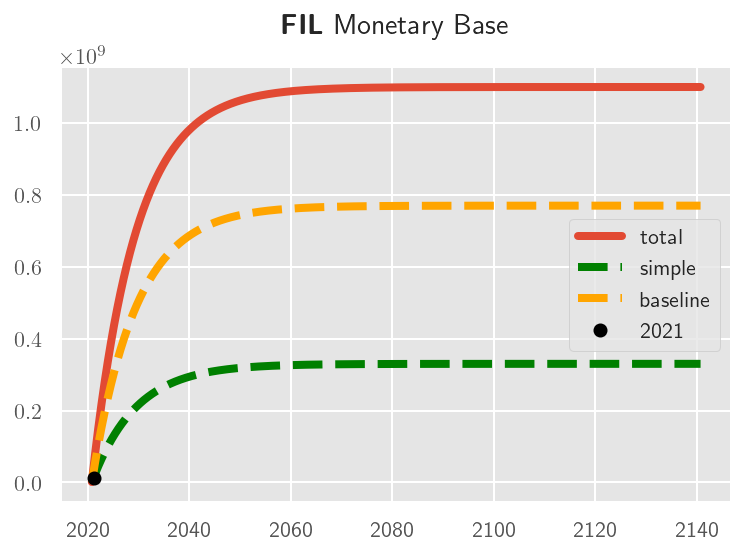

In [55]:
plot_fil_supply_curve(supply)

## Standardize Time Series

In [11]:
weekly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='weekly')

display(weekly_supply.head())
display(weekly_supply.tail())

Wrote 6876 lines to file ../output-data/FIL_weekly.csv


,coin,block,total_supply,total_supply_pct,date
0,FIL,1,50.0,0.000238,2020-10-01
1,FIL,577,28850.0,0.137381,2020-10-01
2,FIL,1585,79250.0,0.377381,2020-10-01
3,FIL,2593,129650.0,0.617381,2020-11-01
4,FIL,3601,180050.0,0.857381,2020-11-01


,coin,block,total_supply,total_supply_pct,date
6871,FIL,6925537,2.100000e+07,100.0,2152-06-01
6872,FIL,6926545,2.100000e+07,100.0,2152-06-01
6873,FIL,6927553,2.100000e+07,100.0,2152-07-01
6874,FIL,6928561,2.100000e+07,100.0,2152-07-01
6875,FIL,6929569,2.100000e+07,100.0,2152-07-01


In [12]:
monthly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='monthly')

display(monthly_supply.head())
display(monthly_supply.tail())

Wrote 1582 lines to file ../output-data/FIL_monthly.csv


,coin,block,total_supply,total_supply_pct,date
0,FIL,1,50.0,0.000238,2020-10-01
1,FIL,2449,122450.0,0.583095,2020-11-01
2,FIL,6769,338450.0,1.611667,2020-12-01
3,FIL,11233,561650.0,2.674524,2021-01-01
4,FIL,15697,784850.0,3.737381,2021-02-01


,coin,block,total_supply,total_supply_pct,date
1577,FIL,6909697,2.100000e+07,100.0,2152-03-01
1578,FIL,6914161,2.100000e+07,100.0,2152-04-01
1579,FIL,6918481,2.100000e+07,100.0,2152-05-01
1580,FIL,6922945,2.100000e+07,100.0,2152-06-01
1581,FIL,6927265,2.100000e+07,100.0,2152-07-01


In [13]:
yearly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='yearly')

display(yearly_supply.head())
display(yearly_supply.tail())

Wrote 133 lines to file ../output-data/FIL_yearly.csv


,coin,block,total_supply,total_supply_pct,date
0,FIL,1,50.0,0.000238,2020-10-01
1,FIL,11233,561650.0,2.674524,2021-01-01
2,FIL,63793,3189650.0,15.188810,2022-01-01
3,FIL,116353,5817650.0,27.703095,2023-01-01
4,FIL,168913,8445650.0,40.217381,2024-01-01


,coin,block,total_supply,total_supply_pct,date
128,FIL,6690673,2.100000e+07,100.0,2148-01-01
129,FIL,6743377,2.100000e+07,100.0,2149-01-01
130,FIL,6795937,2.100000e+07,100.0,2150-01-01
131,FIL,6848497,2.100000e+07,100.0,2151-01-01
132,FIL,6901057,2.100000e+07,100.0,2152-01-01
